<function matplotlib.pyplot.show(close=None, block=None)>

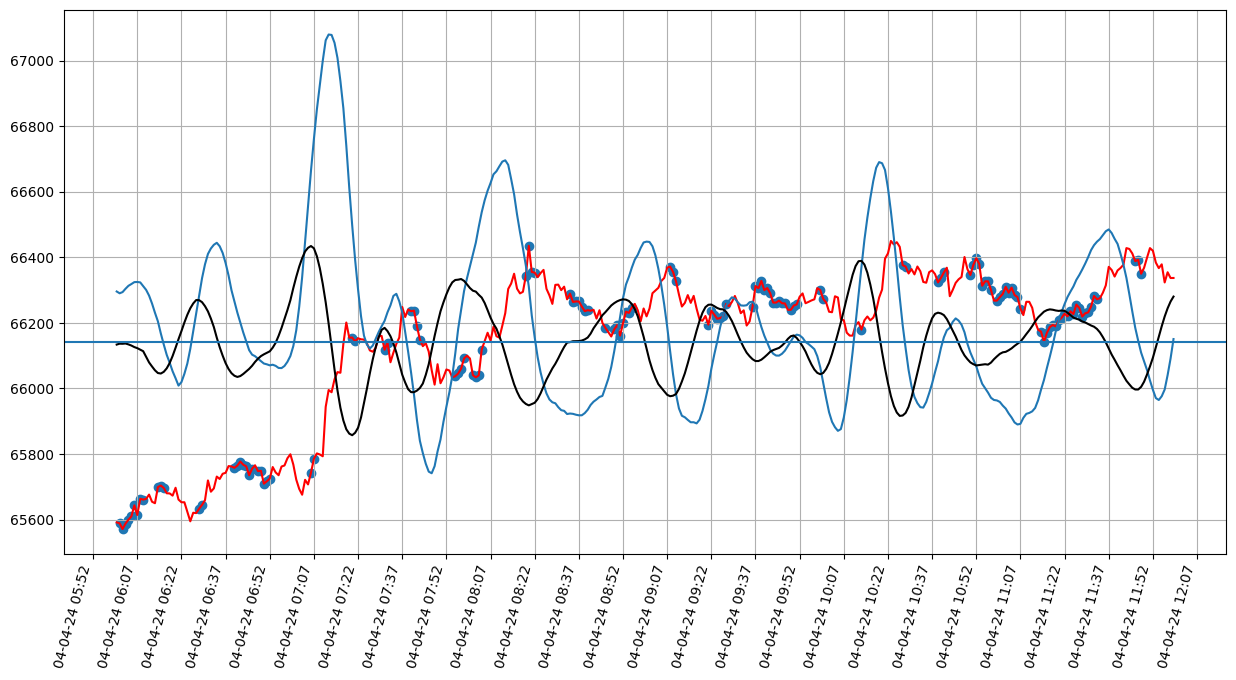

In [62]:
import pandas as pd
import os
import numpy as np
from datetime import datetime
import sympy as sp
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

## Conexión con Binance para descargar la lista de pares que binance maneja
from binance import Client
client = Client()


##################################################################################################################################
# Descarga y limpieza de datos de 5 días en adelante
##################################################################################################################################
recent_data = pd.DataFrame(client.get_historical_klines('BTCUSDT','1m','2 day ago UTC'))
recent_data = recent_data.iloc[:,:6]
recent_data.columns = ['Tiempo','Open','High','Low','Close','Volume']
recent_data['Tiempo'] = pd.to_datetime(recent_data.Tiempo,unit='ms')
#recent_data['Tiempo'] = recent_data.Tiempo.astype('datetime64')
recent_data = recent_data.set_index('Tiempo')
recent_data = recent_data.astype(float)
recent_data = recent_data.reset_index()
recent_data['Interpolacion'] = sc.signal.savgol_filter(recent_data.Open,25,3)
recent_data['Primer_Derivada'] = recent_data.Interpolacion.diff()
recent_data['PD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Primer_Derivada,25,3)
recent_data['Segunda_Derivada'] = recent_data.PD_Interpolacion.diff()
recent_data['SD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Segunda_Derivada,25,3)
recent_data['Tercer_Derivada'] = recent_data.SD_Interpolacion.diff()
recent_data['TD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Tercer_Derivada,25,3)




##################################################################################################################################
# Gráfica final del backtesting sobre nuestro análisis con puntos de compra y venta.
##################################################################################################################################
# a = 1200
# d = 500
initial_date_index = recent_data[recent_data.Tiempo == datetime.strptime('2024-04-04 6:00:00','%Y-%m-%d %H:%M:%S')].index.item()
final_date_index = recent_data[recent_data.Tiempo == datetime.strptime('2024-04-04 12:00:00','%Y-%m-%d %H:%M:%S')].index.item()


min_max_sd = pd.DataFrame(columns=['Derivada'])
min_max_sd['Derivada'] = recent_data[initial_date_index:final_date_index].SD_Interpolacion.diff()
lista_min_max = min_max_sd[(min_max_sd['Derivada'] >= -0.1) & (min_max_sd['Derivada'] <= 0.1)]
indices_min_max = lista_min_max.index.tolist()


######################################################################
# Agregamos el código necesario para encontrar los puntos exactos mínimos y máximos
######################################################################
drlist = []
lista_min_max = lista_min_max.reset_index()
lista_min_max.columns = ['indice','Derivada']
mp = recent_data.Open[initial_date_index:final_date_index].mean()


for i in range(1,len(lista_min_max)-1):
    if (recent_data.SD_Interpolacion.diff()[lista_min_max.indice[i-1]] >= lista_min_max.Derivada[i]) & (recent_data.SD_Interpolacion.diff()[lista_min_max.indice[i+1]] >= lista_min_max.Derivada[i]) & (recent_data.SD_Interpolacion[lista_min_max.indice[i]]*100 < (mp - np.std(recent_data.SD_Interpolacion)*10)):
        drlist.append(lista_min_max.indice[i])
#        minlist.append(lista_min_max[i])
    elif (recent_data.SD_Interpolacion.diff()[lista_min_max.indice[i-1]] <= lista_min_max.Derivada[i]) & (recent_data.SD_Interpolacion.diff()[lista_min_max.indice[i+1]] <= lista_min_max.Derivada[i]) & (recent_data.SD_Interpolacion[lista_min_max.indice[i]]*100 > (mp + np.std(recent_data.SD_Interpolacion)*10)):
        drlist.append(lista_min_max.indice[i])
#        maxlist.append(lista_min_max[i])


######################################################################
# Gráficas resultantes de los análisis anteriores.
######################################################################
# plt.axvline(halving_dates['Halving_Dates'][2])
# plt.axvline(halving_dates['Halving_Dates'][3])
plt.figure(figsize=(15,8))
plt.plot(recent_data.Tiempo[initial_date_index:final_date_index],recent_data.Open[initial_date_index:final_date_index].multiply(1),color='red')
plt.plot(recent_data.Tiempo[initial_date_index:final_date_index],recent_data.PD_Interpolacion[initial_date_index:final_date_index].multiply(30)+mp)
plt.plot(recent_data.Tiempo[initial_date_index:final_date_index],recent_data.SD_Interpolacion[initial_date_index:final_date_index].multiply(100)+mp,color='k')
# for i in recent_data.Tiempo.iloc[lista_min_max]:
#     plt.axvline(i)
plt.scatter(recent_data.Tiempo.iloc[indices_min_max],recent_data.Open.iloc[indices_min_max])
plt.grid(visible=True)

# Set minor tick locations.
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=15))
# plt.gca().xaxis.set_minor_locator(minorLocator)
plt.gcf().autofmt_xdate()
# Set grid to use minor tick locations. 
plt.grid(which = 'minor')
plt.xticks(rotation=75)
plt.axhline(mp)
# plt.axhline(np.std(recent_data.SD_Interpolacion)*10 + mp)
# plt.axhline(mp - np.std(recent_data.SD_Interpolacion)*10)
# plt.axvline(6500)
plt.show

In [9]:
initial_date_index = recent_data[recent_data.Tiempo == datetime.strptime('2024-04-04 09:59:00','%Y-%m-%d %H:%M:%S')].index.item()
final_date_index = recent_data[recent_data.Tiempo == datetime.strptime('2024-04-04 11:00:00','%Y-%m-%d %H:%M:%S')].index.item()

In [12]:
recent_data[1340:1380]

,Tiempo,Open,High,Low,Close,Volume,Interpolacion,Primer_Derivada,PD_Interpolacion,Segunda_Derivada,SD_Interpolacion,Tercer_Derivada,TD_Interpolacion
1340,2024-04-04 09:38:00,66306.01,66328.05,66306.00,66328.04,4.40564,66275.079979,0.387310,2.565037,-1.130043,-0.574383,-0.000021,-0.041916
1341,2024-04-04 09:39:00,66328.05,66328.05,66300.00,66300.00,10.56375,66274.332897,-0.747082,1.538425,-1.026612,-0.533006,0.041377,-0.008609
1342,2024-04-04 09:40:00,66300.01,66328.00,66300.00,66306.26,8.21595,66274.012843,-0.320054,0.662661,-0.875764,-0.460166,0.072840,0.021786
1343,2024-04-04 09:41:00,66306.27,66306.27,66290.33,66290.34,3.51891,66272.950189,-1.062653,-0.052103,-0.714764,-0.379140,0.081026,0.046155
1344,2024-04-04 09:42:00,66290.33,66290.34,66262.06,66262.07,9.31743,66274.550184,1.599994,-0.753202,-0.701099,-0.291254,0.087886,0.064807
1345,2024-04-04 09:43:00,66262.07,66262.07,66262.06,66262.07,3.42285,66277.127028,2.576844,-1.165102,-0.411900,-0.241709,0.049545,0.076573
1346,2024-04-04 09:44:00,66262.06,66268.00,66262.06,66268.00,2.59273,66278.282703,1.155675,-1.356006,-0.190904,-0.206991,0.034719,0.078532
1347,2024-04-04 09:45:00,66268.00,66285.84,66260.02,66260.14,20.12744,66277.023886,-1.258817,-1.363008,-0.007001,-0.173131,0.033859,0.071901
1348,2024-04-04 09:46:00,66260.14,66275.74,66255.05,66259.30,4.02424,66273.981666,-3.042220,-1.176574,0.186433,-0.102278,0.070854,0.056950
1349,2024-04-04 09:47:00,66259.30,66274.95,66240.00,66240.00,9.22231,66267.988095,-5.993571,-0.858196,0.318378,-0.014317,0.087961,0.035325


In [3]:
PMSD = initial_date_index
recent_data[PMSD-rango:PMSD+rango][recent_data.SD_Interpolacion[PMSD-rango:PMSD+rango] == pmax].index.item()

1302

In [16]:
indices_min_max

[1123,
 1124,
 1125,
 1126,
 1127,
 1128,
 1129,
 1130,
 1131,
 1136,
 1137,
 1138,
 1150,
 1151,
 1162,
 1163,
 1164,
 1165,
 1166,
 1167,
 1168,
 1170,
 1171,
 1172,
 1173,
 1174,
 1188,
 1189,
 1202,
 1203,
 1213,
 1214,
 1222,
 1223,
 1224,
 1225,
 1237,
 1238,
 1239,
 1240,
 1243,
 1244,
 1245,
 1246,
 1261,
 1262,
 1263,
 1264,
 1276,
 1277,
 1278,
 1279,
 1280,
 1281,
 1282,
 1288,
 1291,
 1292,
 1293,
 1294,
 1295,
 1296,
 1297,
 1310,
 1311,
 1312,
 1323,
 1324,
 1325,
 1326,
 1327,
 1328,
 1329,
 1338,
 1339,
 1340,
 1341,
 1342,
 1343,
 1344,
 1345,
 1346,
 1347,
 1348,
 1349,
 1351,
 1352,
 1353,
 1361,
 1362,
 1375,
 1389,
 1390,
 1401,
 1402,
 1403,
 1412,
 1413,
 1414,
 1415,
 1416,
 1417,
 1418,
 1419,
 1421,
 1422,
 1423,
 1424,
 1425,
 1426,
 1427,
 1428,
 1429,
 1436,
 1437,
 1438,
 1439,
 1440,
 1441,
 1442,
 1443,
 1444,
 1445,
 1446,
 1447,
 1448,
 1449,
 1450,
 1451,
 1452,
 1453,
 1454,
 1455,
 1468,
 1469,
 1470]

In [23]:
recent_data[PMSD-5:PMSD+5][recent_data.TD_Interpolacion[PMSD-5:PMSD+5] == -2.83660148912158].index

Int64Index([], dtype='int64')

<function matplotlib.pyplot.show(close=None, block=None)>

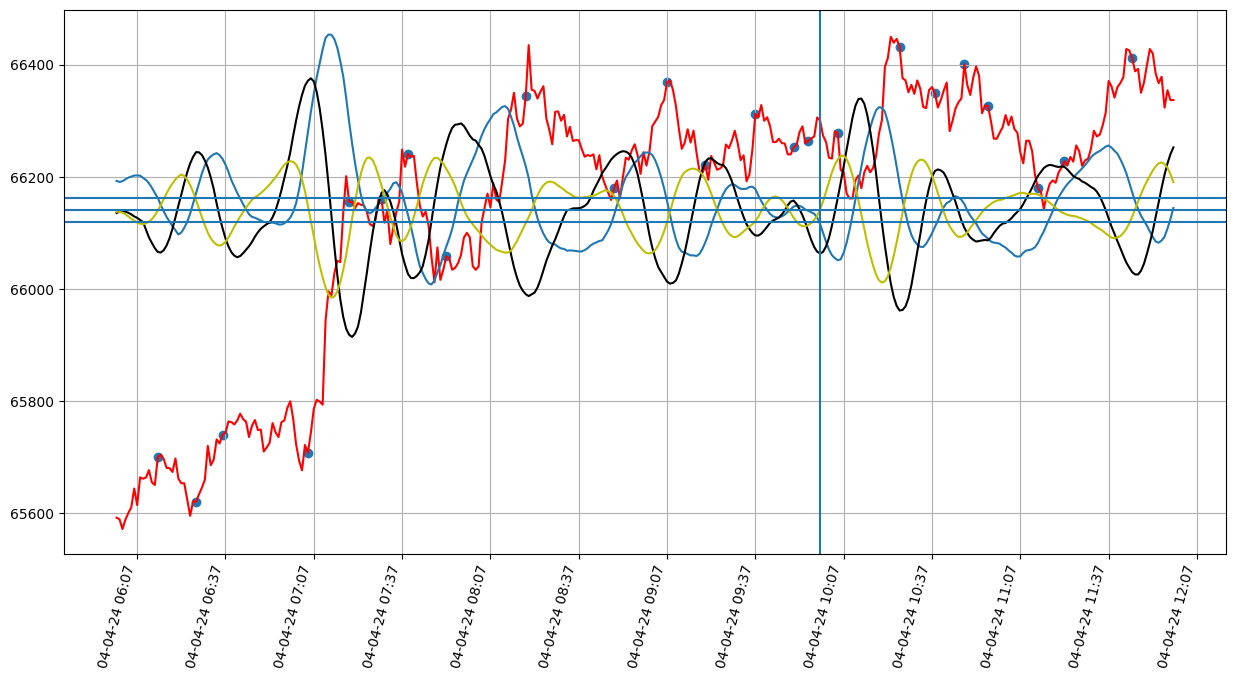

In [63]:
initial_date_index = recent_data[recent_data.Tiempo == datetime.strptime('2024-04-04 6:00:00','%Y-%m-%d %H:%M:%S')].index.item()
final_date_index = recent_data[recent_data.Tiempo == datetime.strptime('2024-04-04 12:00:00','%Y-%m-%d %H:%M:%S')].index.item()

min_max_sd = pd.DataFrame(columns=['Derivada'])
min_max_sd['Derivada'] = recent_data[initial_date_index:final_date_index].Tercer_Derivada
lista_min_max = min_max_sd[(min_max_sd['Derivada'] >= -0.1) & (min_max_sd['Derivada'] <= 0.1)]
indices_min_max = lista_min_max.index.tolist()

max_points_idx = []
min_points_idx = []
mm_points_idx = []

rango = 15
for i in range(len(indices_min_max)):
    PMSD = indices_min_max[i]
    if recent_data.SD_Interpolacion[PMSD:PMSD+1].item() > 0:
        pmax = recent_data.SD_Interpolacion[PMSD]
        for i in range(rango+1):
            if recent_data.SD_Interpolacion[PMSD-i] > pmax:
                pmax_idx = PMSD-i
            elif recent_data.SD_Interpolacion[PMSD+i] > pmax:
                pmax_idx = PMSD+i
        max_points_idx.append(pmax_idx)
    elif recent_data.SD_Interpolacion[PMSD:PMSD+1].item() < 0:
        pmin = recent_data.SD_Interpolacion[PMSD]
        for i in range(rango+1):
            if recent_data.SD_Interpolacion[PMSD-i] < pmin:
                pmin_idx = PMSD-i
            elif recent_data.SD_Interpolacion[PMSD+i] < pmin:
                pmin_idx = PMSD+i
        min_points_idx.append(pmin_idx)
max_points_idx = list(set(max_points_idx))
min_points_idx = list(set(min_points_idx))
max_points_idx.extend(min_points_idx)
max_points_idx.sort()
mm_points_idx = max_points_idx
close_points = []
for i in range(len(mm_points_idx)-1):
    if mm_points_idx[i+1]-mm_points_idx[i] <= 2:
        close_points.append(i+1)
for idx in sorted(close_points,reverse=True):
    del mm_points_idx[idx]


min_max_sd = pd.DataFrame(columns=['Derivada'])
min_max_sd['Derivada'] = recent_data[initial_date_index:final_date_index].SD_Interpolacion.diff()
lista_min_max = min_max_sd[(min_max_sd['Derivada'] >= -0.01) & (min_max_sd['Derivada'] <= 0.01)]
indices_min_max = lista_min_max.index.tolist()


######################################################################
# Agregamos el código necesario para encontrar los puntos exactos mínimos y máximos
######################################################################
drlist = []
lista_min_max = lista_min_max.reset_index()
lista_min_max.columns = ['indice','Derivada']
mp = recent_data.Open[initial_date_index:final_date_index].mean()


for i in range(1,len(lista_min_max)-1):
    if (recent_data.SD_Interpolacion.diff()[lista_min_max.indice[i-1]] >= lista_min_max.Derivada[i]) & (recent_data.SD_Interpolacion.diff()[lista_min_max.indice[i+1]] >= lista_min_max.Derivada[i]) & (recent_data.SD_Interpolacion[lista_min_max.indice[i]]*100 < (mp - np.std(recent_data.SD_Interpolacion)*20)):
        drlist.append(lista_min_max.indice[i])
#        minlist.append(lista_min_max[i])
    elif (recent_data.SD_Interpolacion.diff()[lista_min_max.indice[i-1]] <= lista_min_max.Derivada[i]) & (recent_data.SD_Interpolacion.diff()[lista_min_max.indice[i+1]] <= lista_min_max.Derivada[i]) & (recent_data.SD_Interpolacion[lista_min_max.indice[i]]*100 > (mp + np.std(recent_data.SD_Interpolacion)*20)):
        drlist.append(lista_min_max.indice[i])
#        maxlist.append(lista_min_max[i])

mp = recent_data.Open[initial_date_index:final_date_index].mean()
plt.figure(figsize=(15,8))
plt.plot(recent_data.Tiempo[initial_date_index:final_date_index],recent_data.Open[initial_date_index:final_date_index].multiply(1),color='red')
plt.plot(recent_data.Tiempo[initial_date_index:final_date_index],recent_data.PD_Interpolacion[initial_date_index:final_date_index].multiply(10)+mp)
plt.plot(recent_data.Tiempo[initial_date_index:final_date_index],recent_data.SD_Interpolacion[initial_date_index:final_date_index].multiply(80)+mp,color='k')
plt.plot(recent_data.Tiempo[initial_date_index:final_date_index],recent_data.TD_Interpolacion[initial_date_index:final_date_index].multiply(300)+mp,color='y')
# for i in recent_data.Tiempo.iloc[lista_min_max]:
#     plt.axvline(i)
plt.axvline(datetime.strptime('2024-04-04 09:59:00','%Y-%m-%d %H:%M:%S'))
plt.scatter(recent_data.Tiempo.iloc[mm_points_idx],recent_data.Open.iloc[mm_points_idx])
plt.grid(visible=True)

# Set minor tick locations.
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
# plt.gca().yaxis.set_major_locator(ticker.LinearLocator(interval=5))
# plt.gca().xaxis.set_minor_locator(minorLocator)
plt.gcf().autofmt_xdate()
# Set grid to use minor tick locations. 
plt.grid(which = 'minor')
plt.xticks(rotation=75)
plt.axhline(mp)
plt.axhline(np.std(recent_data.SD_Interpolacion)*12 + mp)
plt.axhline(mp - np.std(recent_data.SD_Interpolacion)*12)
plt.show
# d = 500

In [ ]:
recent_data[]

<function matplotlib.pyplot.show(close=None, block=None)>

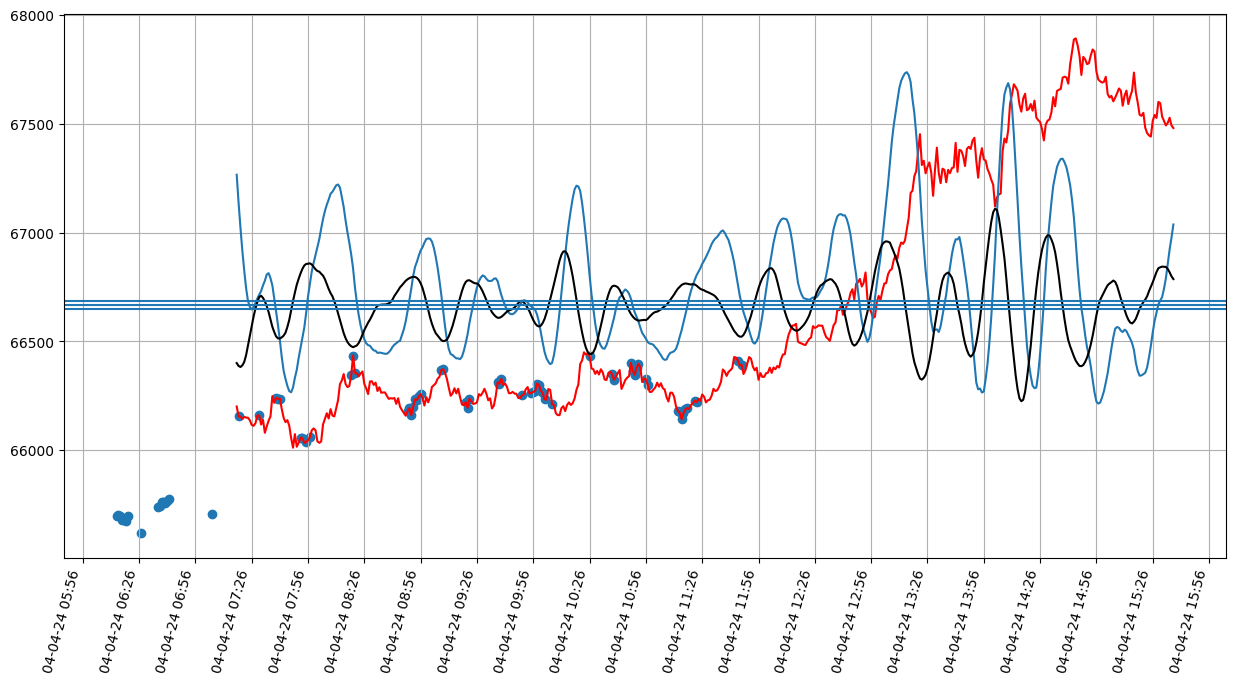

In [57]:
a = 1200
d = 500

mp = recent_data.Open[a:a+d].mean()
plt.figure(figsize=(15,8))
plt.plot(recent_data.Tiempo[a:a+d],recent_data.Open[a:a+d].multiply(1),color='red')
plt.plot(recent_data.Tiempo[a:a+d],recent_data.PD_Interpolacion[a:a+d].multiply(30)+mp)
plt.plot(recent_data.Tiempo[a:a+d],recent_data.SD_Interpolacion[a:a+d].multiply(100)+mp,color='k')
# for i in recent_data.Tiempo.iloc[lista_min_max]:
#     plt.axvline(i)
plt.scatter(recent_data.Tiempo.iloc[mm_points_idx],recent_data.Open.iloc[mm_points_idx])
plt.grid(visible=True)

# Set minor tick locations.
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
# plt.gca().xaxis.set_minor_locator(minorLocator)
plt.gcf().autofmt_xdate()
# Set grid to use minor tick locations. 
plt.grid(which = 'minor')
plt.xticks(rotation=75)
plt.axhline(mp)
plt.axhline(np.std(recent_data.SD_Interpolacion)*10 + mp)
plt.axhline(mp - np.std(recent_data.SD_Interpolacion)*10)
# plt.axvline(6500)
plt.show

In [ ]:
for i in 

In [7]:
lista_min_max

,indice,Derivada
0,1304,0.071363
1,1305,0.022733
2,1306,-0.046438
3,1307,-0.089576
4,1314,-0.094158
...,...,...
183,1779,-0.052971
184,1780,0.079325
185,1792,0.085756
186,1793,0.047144
